# MLFlow Tracking Introduction

MLflow Tracking provides both an API and UI dedicated to the logging of parameters, code versions, metrics, and artifacts during the ML process. This centralized repository captures details such as parameters, metrics, artifacts, data, and environment configurations, giving teams insight into their models’ evolution over time. Whether working in standalone scripts, notebooks, or other environments, Tracking facilitates the logging of results either to local files or a server, making it easier to compare multiple runs across different users.

Reference: https://mlflow.org/docs/latest/tracking.html

## Example of usage (training a neural network on the iris dataset and logging the results):

In [1]:
import mlflow
import torch
import numpy as np

# Create a data loader from sklearn's iris dataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torch.utils import data as torch_data

In [2]:
# Load the iris dataset
iris = load_iris()
matrix_x = iris.data
array_y = iris.target

# Scale the data
matrix_x = (matrix_x - matrix_x.mean(axis=0)) / matrix_x.std(axis=0)

# Transform the array_y label as a probability distribution (Dirac distribution)
# e.g. 2 -> [0, 0, 1] (the second class has probability 1)
# In fact PyTorch's CrossEntropyLoss does this transformation internally apparently
# But we do it here for the sake of the example
matrix_y = np.zeros((array_y.shape[0], 3))
matrix_y[np.arange(array_y.shape[0]), array_y] = 1

matrix_x_train, matrix_x_test, matrix_y_train, matrix_y_test = train_test_split(matrix_x, matrix_y, test_size=0.2)

train_dataset = torch_data.TensorDataset(torch.tensor(matrix_x_train).float(), torch.tensor(matrix_y_train).float())
test_dataset = torch_data.TensorDataset(torch.tensor(matrix_x_test).float(), torch.tensor(matrix_y_test).float())

In [3]:
# Create a neural network

dim_x = 4
dim_y = 3
n_layers = 2
n_hidden_neurons = 20

learning_rate = 0.01
epochs = 250
batch_size = 50

train_loader = torch_data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch_data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Build a neural network model
model = torch.nn.Sequential()
for i in range(n_layers):
    if i == 0:
        model.add_module('linear' + str(i), torch.nn.Linear(dim_x, n_hidden_neurons))
    else:
        model.add_module('linear' + str(i), torch.nn.Linear(n_hidden_neurons, n_hidden_neurons))
    model.add_module('relu' + str(i), torch.nn.ReLU())
model.add_module('output', torch.nn.Linear(n_hidden_neurons, dim_y))

# Create a loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Create an optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Train the model and track the experiment with MLFlow

In [4]:
# Train the model

# Set path where tracking data is stored (tracking URI)
# This will create a local mlflow/ folder
# path_tracking_uri = "./"
# mlflow.set_tracking_uri(path_tracking_uri)

# Set experiment name
name_experiment = 'iris_experiment'

# Create the experiment only if it does not exist
# If it exists, MLflow will use it
if mlflow.get_experiment_by_name(name_experiment) is None:
    mlflow.create_experiment(name_experiment)

# Get the ID of the newly created experiment
experiment_id = mlflow.get_experiment_by_name(name_experiment).experiment_id

# Set the name of the run (optional)
# If not set, MLflow will use a random UUID
run_name = 'first_training'

# Add a description (optional)
description = 'Training a first neural network on the iris dataset'

# Start the experiment
# Note: the experiment will be created in the mlflow/ folder
with mlflow.start_run(experiment_id=experiment_id,
                      run_name=run_name,
                      description=description):
    # Log the parameters
    mlflow.log_param('dim_x', dim_x)
    mlflow.log_param('dim_y', dim_y)
    mlflow.log_param('n_layers', n_layers)
    mlflow.log_param('n_hidden_neurons', n_hidden_neurons)
    mlflow.log_param('learning_rate', learning_rate)
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('batch_size', batch_size)

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            # Forward pass
            tensor2d_y_pred = model(data)  # Shape: (batch_size, dim_y)

            # Compute Loss
            loss = loss_fn(tensor2d_y_pred, target)  # Shape: (1)

            # Zero gradients, this is needed by torch else gradients will be accumulated
            optimizer.zero_grad()

            # Backward pass: retropropagate the gradients
            loss.backward()

            # Update weights: apply one gradient step to minimize loss
            optimizer.step()

        # Compute accuracy on test set
        with torch.no_grad():
            tensor2d_y_pred_test = model(torch.tensor(matrix_x_test).float())
            loss_test = loss_fn(tensor2d_y_pred_test, torch.tensor(matrix_y_test).float())

        # Print metrics
        print('Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
        print('Epoch: {} \tLoss test: {:.6f}'.format(epoch, loss_test.item()))

        # Log metrics
        mlflow.log_metric('loss', loss.item())

Epoch: 0 	Loss: 1.130309
Epoch: 0 	Loss test: 1.101957
Epoch: 1 	Loss: 1.105363
Epoch: 1 	Loss test: 1.096857
Epoch: 2 	Loss: 1.122221
Epoch: 2 	Loss test: 1.091860
Epoch: 3 	Loss: 1.132230
Epoch: 3 	Loss test: 1.086882
Epoch: 4 	Loss: 1.103860
Epoch: 4 	Loss test: 1.082111
Epoch: 5 	Loss: 1.090570
Epoch: 5 	Loss test: 1.077337
Epoch: 6 	Loss: 1.077251
Epoch: 6 	Loss test: 1.072814
Epoch: 7 	Loss: 1.059893
Epoch: 7 	Loss test: 1.068476
Epoch: 8 	Loss: 1.090483
Epoch: 8 	Loss test: 1.064035
Epoch: 9 	Loss: 1.039955
Epoch: 9 	Loss test: 1.059631
Epoch: 10 	Loss: 1.110841
Epoch: 10 	Loss test: 1.055135
Epoch: 11 	Loss: 1.046055
Epoch: 11 	Loss test: 1.050753
Epoch: 12 	Loss: 1.050607
Epoch: 12 	Loss test: 1.046378
Epoch: 13 	Loss: 1.065716
Epoch: 13 	Loss test: 1.042011
Epoch: 14 	Loss: 1.053201
Epoch: 14 	Loss test: 1.037850
Epoch: 15 	Loss: 1.018272
Epoch: 15 	Loss test: 1.033615
Epoch: 16 	Loss: 1.009029
Epoch: 16 	Loss test: 1.029273
Epoch: 17 	Loss: 1.027388
Epoch: 17 	Loss test: 1.0

### Reaching the MLFlow UI

The MLFlow Tracking UI is an interactive web interface that allows you to visualize your experiments and compare runs.
See the image below for an illustration of the UI.

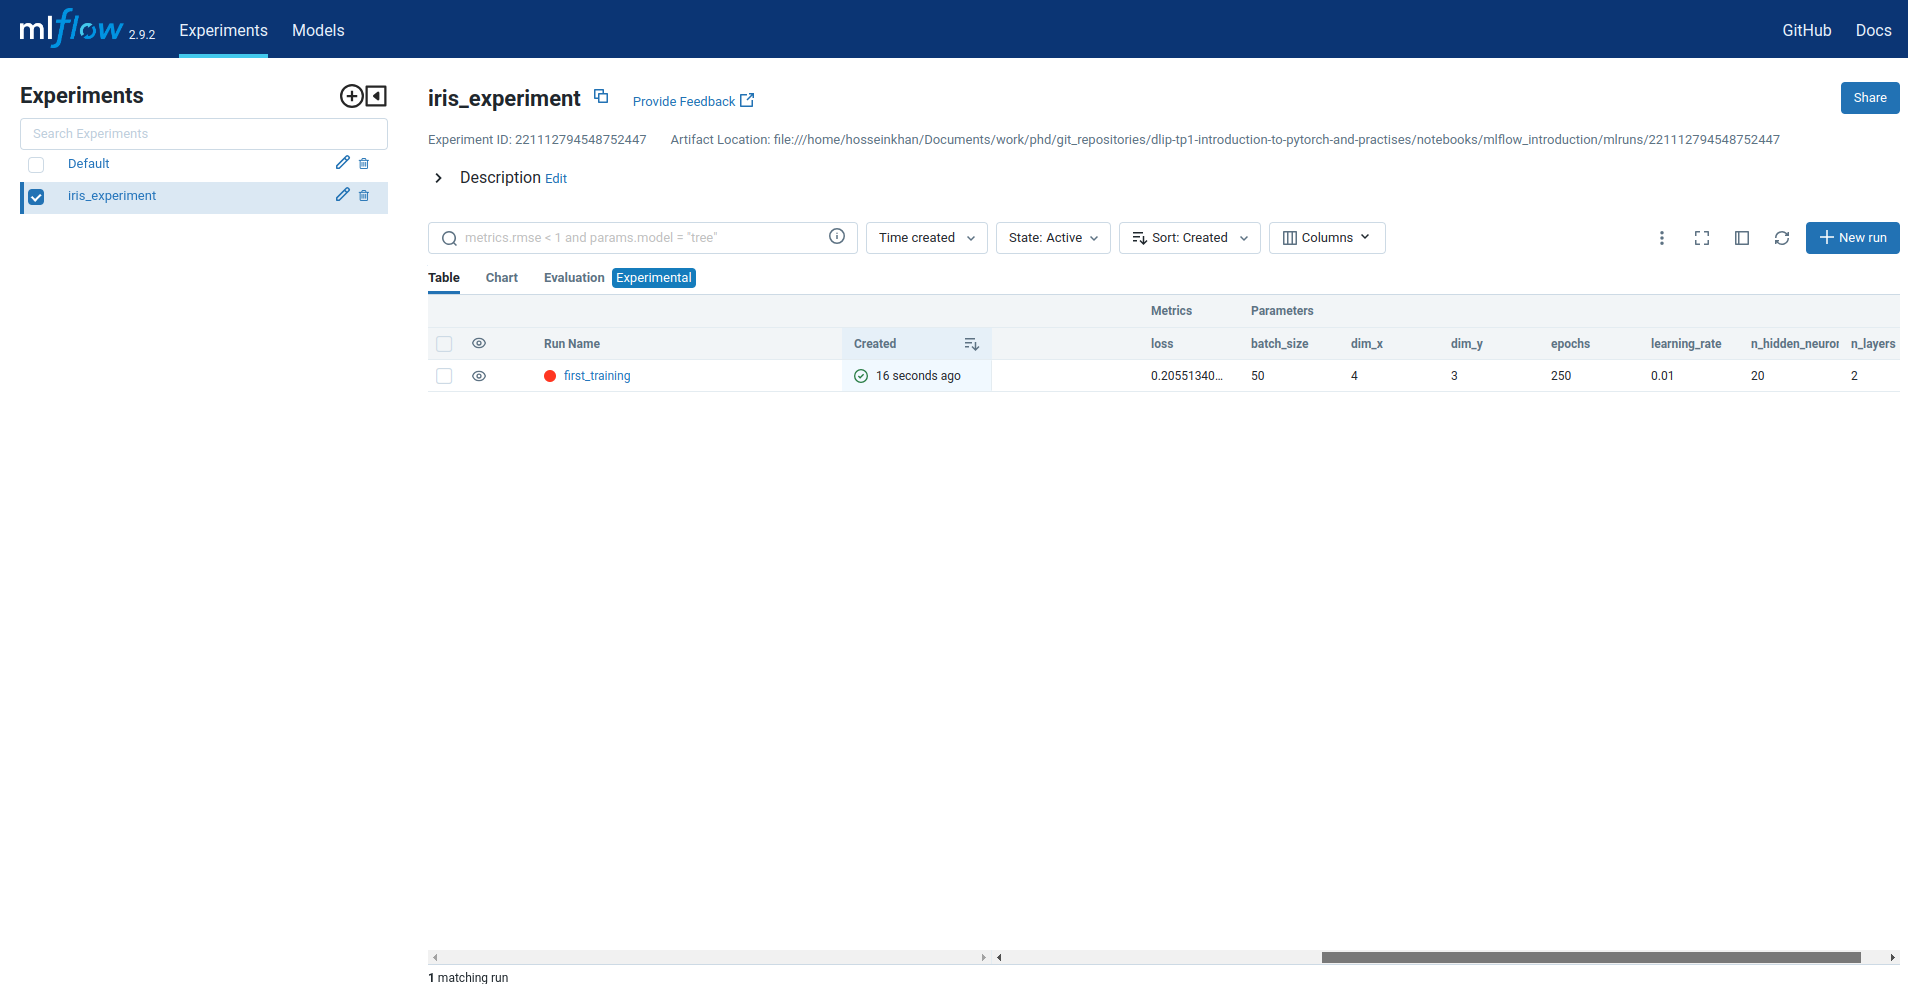

In [5]:
# Illustration of the MLFlow UI
from IPython.display import Image
Image(filename='images/mlflow_tracking_interface.png')

The UI can be launched with the following command:

In [ ]:
# Launch the MLFlow UI
!mlflow ui --port 5002

The UI can be accessed at http://localhost:5002

Many more features are available, browse the documentation for more details.
More examples are available here: https://mlflow.org/docs/latest/tutorials-and-examples/index.html
Python API reference: https://mlflow.org/docs/latest/python_api/index.html

Author: Hosseinkhan Boucher Rémy